## Model: KMeans
Attribute Selection: None

In [18]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from kneed import KneeLocator
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

def interpret_confusion_matrix(matrix, title, labels):
    encode, correct, errors, total = [],[],[],[]
    i=0
    for row in matrix:
        total.append(sum(row))
        correct.append(row[i])
        
        consider = row.tolist() 
        del consider[i] #remove correctly classified instances

        errors.append(sum(consider))
        i+=1

    fig = go.Figure(data=[go.Table(columnwidth=5, header=dict(values=["Class","Correctly Classified","Incorrectly Classified","Total"]),cells=dict(values=[labels, correct, errors, total]))])
    fig.update_layout(title= title,width=650,height=400)

    fig.show()

def gather_inertia(min,max,train,test):
    inertia= []
    for i in range(min,max):
        clf = KMeans(n_clusters=i, random_state=42, n_init=10)
        clf.fit(train,test)
        inertia.append(clf.inertia_)

    k = KneeLocator([*range(min,max)], inertia, curve="convex",direction="decreasing")
    k.plot_knee()
    
    print("The estimated right k value is: ",k.knee)
    return k.knee

def update_dictionary(class_,dct):
    if class_ in dct:
        dct[class_]+=1
    else:
        dct[class_]=0
    return dct

def gather_prediction_info(labels,ypred,y_test,title):
    results={0:{},1:{},2:{}}

    for i in range(len(ypred)):
        class_attribute = labels[int(y_test.tolist()[i])]
        predicted = ypred[i]
        if predicted == 0:
            update_dictionary(class_attribute,results[0])
        elif predicted == 1:
            update_dictionary(class_attribute,results[1])
        else:
            update_dictionary(class_attribute,results[2])
    
    fig,axis = plt.subplots(3,1, figsize=(7,8))

    axis[0].bar(results[0].keys(),results[0].values(),color =["#dab49d","#6969b3","#5E3023"],width=0.4,edgecolor ="black")
    axis[0].set_title('Cluster 0 '+title,loc='left', fontweight='bold',  style='italic')
    axis[0].tick_params(axis='x',  labelsize=8)

    axis[1].bar(results[1].keys(),results[1].values(),color=["#C08552","#3E5641","#001242","#D0BCD5"],width=0.4,edgecolor ="black")
    axis[1].set_title('Cluster 1 '+title,loc='left', fontweight='bold',  style='italic')
    axis[1].tick_params(axis='x',  labelsize=8)


    axis[2].bar(results[2].keys(),results[2].values(),color = ["#5E3023","#6969b3","#D0BCD5","#001242","#3E5641"],width=0.4,edgecolor ="black")
    axis[2].set_title('Cluster 2 '+title,loc='left', fontweight='bold',  style='italic')
    axis[2].tick_params(axis='x',  labelsize=8)

    fig.tight_layout()
    plt.show()

labels = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]

In [19]:
df = pd.read_csv("Data/DataEncoded.csv")

X=df.iloc[:,:-1]
y=df["NObeyesdad"]

#### Training, Testing

The estimated right k value is:  3


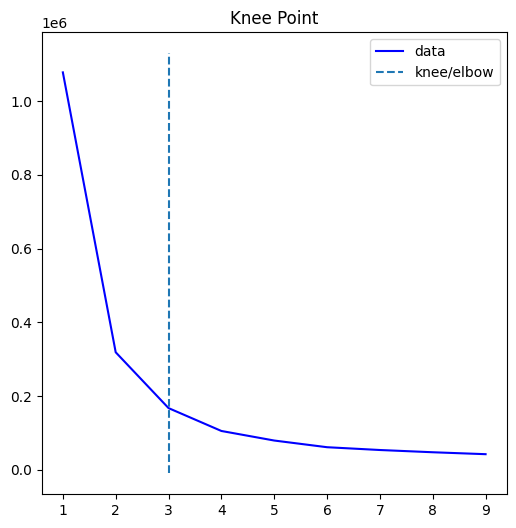

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)
k=gather_inertia(1,10,X_train,y_train)

Kmeans = KMeans(n_clusters=k,random_state=42,n_init=10)
Kmeans.fit(X_train,y_train)
ypred=Kmeans.predict(X_test)

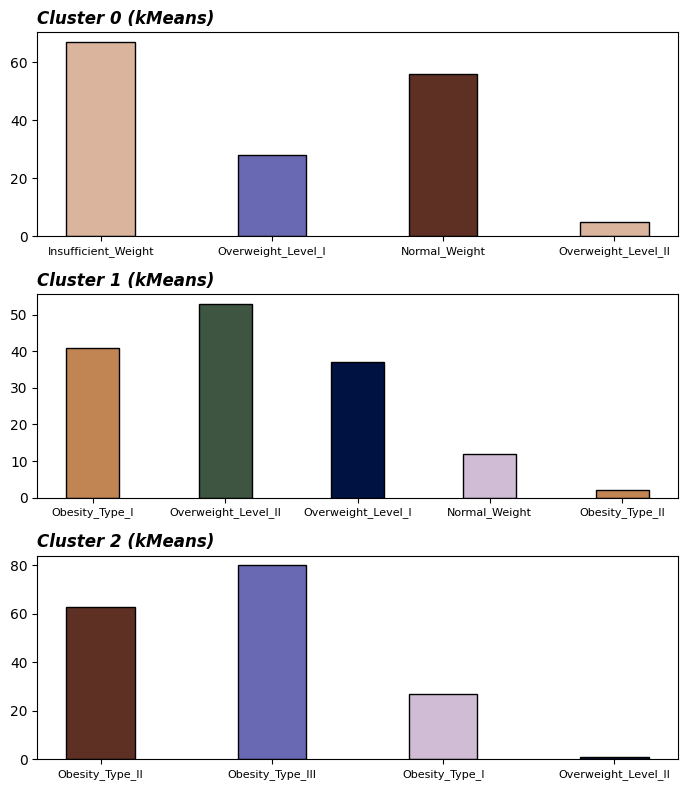

Silhoutte Score: 0.035482685317727185
Cross Validation Score: -16980.307273009308
Precision Score: 0.07209621993127148
Recall Score: 0.1670103092783505
F1 score: 0.1006889294463901
Accuracy: 0.1670103092783505

Confusion Matrix 
----------------


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



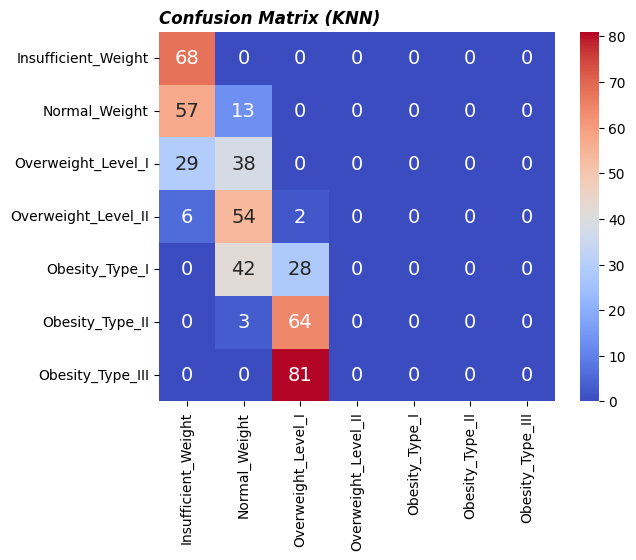

In [21]:
gather_prediction_info(labels,ypred,y_test,"(kMeans)")
print("Silhoutte Score: "+str(silhouette_score(X_train,y_train)))

cv_score = np.array(cross_val_score(Kmeans, X_train,y_train, cv=10)).mean()
cf_matrix = confusion_matrix(y_test,ypred)
metrics = precision_recall_fscore_support(y_test,ypred,average="weighted")
precision,recall,f1=metrics[0],metrics[1],metrics[2]
accuracy= accuracy_score(y_test,ypred)

print("Cross Validation Score: {0}\nPrecision Score: {1}\nRecall Score: {2}\nF1 score: {3}\nAccuracy: {4}".format(cv_score,precision,recall,f1,accuracy))

print("\nConfusion Matrix \n----------------")
sns.heatmap(pd.DataFrame(cf_matrix, labels, labels), annot=True, annot_kws={"size": 14},cmap = 'coolwarm') # font size
plt.title("Confusion Matrix (KNN)",loc='left', fontweight='bold',  style='italic')
plt.show()

interpret_confusion_matrix(cf_matrix,"Breakdown of Confusion Matrix (kMeans)", labels)    

 The silhouette score for the training data is 0.03258. Since the score is close to zero that means that the clusters are overlapping. This can be seen when you test the model in the figure above. Let's try incorperating the silhoutte score in our method to determine the k value then using a KD tree

<Figure size 2000x600 with 0 Axes>

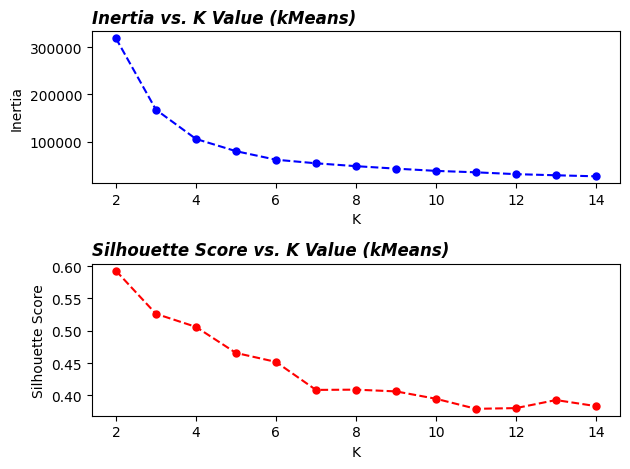

In [22]:
inertia= []
silhouette=[]

for i in range(2,15):
    clf = KMeans(n_clusters=i, random_state=42, n_init=10)
    clf.fit(X_train,y_train)
    inertia.append(clf.inertia_)
    silhouette.append(silhouette_score(X_train,clf.labels_))

plt.figure(figsize=(20,6))
fig,axis = plt.subplots(2,1)

axis[0].plot(range(2,15),inertia,color='blue', linestyle='dashed',marker='o',markerfacecolor='b', markersize=5)
axis[0].set_xlabel('K')
axis[0].set_title('Inertia vs. K Value (kMeans)',loc='left', fontweight='bold',  style='italic')
axis[0].set_ylabel('Inertia')

axis[1].plot(range(2,15),silhouette,color='r', linestyle='dashed',marker='o',markerfacecolor='r', markersize=5)
axis[1].set_title('Silhouette Score vs. K Value (kMeans)',loc='left', fontweight='bold',  style='italic')
axis[1].set_xlabel('K')
axis[1].set_ylabel('Silhouette Score')
fig.tight_layout()
plt.show()

The silhouette score is at its highest when the k = 2, but so is the inertia. Lets try removing insignificant attributes to see if it will improve the score.

<Figure size 2000x600 with 0 Axes>

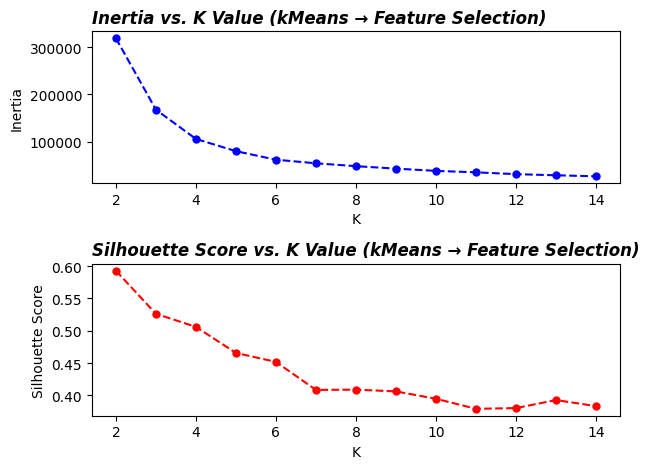

In [23]:
df_correlation = pd.read_csv("Data/Data_CorrelationBasedFeatureSelection.csv")

X_corr=df.iloc[:,:-1]
y_corr=df["NObeyesdad"]

Xtrain,Xtest,ytrain,ytest = train_test_split(X_corr,y_corr,random_state=42,stratify=y_corr)

inertia= []
silhouette=[]

for i in range(2,15):
    clf_corr = KMeans(n_clusters=i, random_state=42, n_init=10,init='k-means++')
    clf_corr.fit(Xtrain,ytrain)
    inertia.append(clf_corr.inertia_)
    silhouette.append(silhouette_score(Xtrain,clf_corr.labels_))

plt.figure(figsize=(20,6))
fig,axis = plt.subplots(2,1)

axis[0].plot(range(2,15),inertia,color='blue', linestyle='dashed',marker='o',markerfacecolor='b', markersize=5)
axis[0].set_xlabel('K')
axis[0].set_title('Inertia vs. K Value (kMeans → Feature Selection)',loc='left', fontweight='bold',  style='italic')
axis[0].set_ylabel('Inertia')
axis[1].plot(range(2,15),silhouette,color='r', linestyle='dashed',marker='o',markerfacecolor='r', markersize=5)
axis[1].set_title('Silhouette Score vs. K Value (kMeans → Feature Selection)',loc='left', fontweight='bold',  style='italic')
axis[1].set_xlabel('K')
axis[1].set_ylabel('Silhouette Score')
fig.tight_layout()
plt.show()

Silhouette Score After Improvements:  0.5262196555212458


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross Validation Score: -16980.307273009308
Precision Score: 0.07209621993127148
Recall Score: 0.1670103092783505
F1 score: 0.1006889294463901
Accuracy: 0.1670103092783505

Confusion Matrix 
----------------


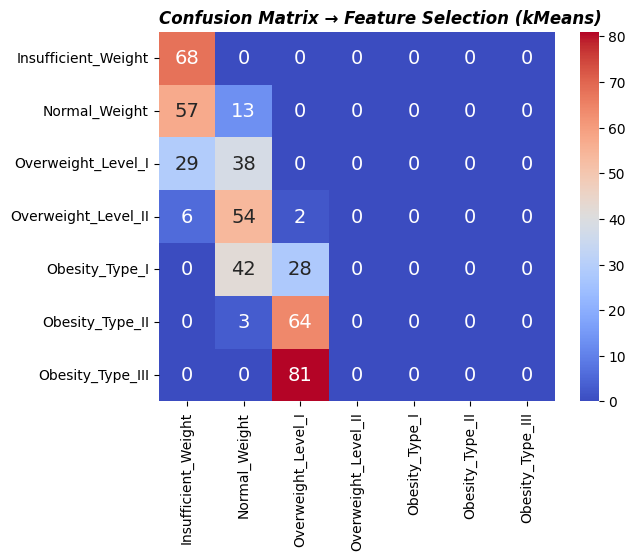

In [24]:
Kmeans_updated = KMeans(n_clusters=3,random_state=42,n_init=10,init='k-means++')
Kmeans_updated.fit(Xtrain,ytrain)
ypred_updated=Kmeans_updated.predict(Xtest)
print("Silhouette Score After Improvements: ", silhouette_score(Xtrain,Kmeans_updated.labels_))

cv_score = np.array(cross_val_score(Kmeans_updated, X_train,y_train, cv=10)).mean()
cf_matrix = confusion_matrix(y_test,ypred)
metrics = precision_recall_fscore_support(y_test,ypred,average="weighted")
precision,recall,f1=metrics[0],metrics[1],metrics[2]
accuracy= accuracy_score(y_test,ypred)

print("Cross Validation Score: {0}\nPrecision Score: {1}\nRecall Score: {2}\nF1 score: {3}\nAccuracy: {4}".format(cv_score,precision,recall,f1,accuracy))
print("\nConfusion Matrix \n----------------")
sns.heatmap(pd.DataFrame(cf_matrix, labels, labels), annot=True, annot_kws={"size": 14},cmap = 'coolwarm') # font size
plt.title("Confusion Matrix → Feature Selection (kMeans)",loc='left', fontweight='bold',  style='italic')
plt.show()

interpret_confusion_matrix(cf_matrix,"Breakdown of Confusion Matrix → Feature Selection (kMeans)", labels)   
# gather_prediction_info(labels,ypred_updated,ytest)

The silhouette score did increase but the labels are still overlapping.